In [1]:
# include("PyrochloreGeometry.jl")
# import .PyrochloreGeometry as geom
include("SpinonStructure.jl")
using BenchmarkTools


In [2]:
L = 5
lat = geom.PyroFCC(L)

# check that these are correct
for (i, ss) in enumerate(lat.spin_sites)
    @assert i == geom.spin_idx(lat, ss)
end

for (i, ts) in enumerate(lat.tetra_sites)
    @assert i == geom.tetra_idx(lat, ts)
end

In [3]:
L = 2
lat = geom.PyroFCC(L)
# SVector{3,Float64}(0,0,0)

@benchmark geom.tetra_idx(lat, lat.tetra_sites[rand(1:8*L^3)])

BenchmarkTools.Trial: 10000 samples with 9 evaluations.
 Range (min … max):  2.153 μs … 457.551 μs  ┊ GC (min … max): 0.00% … 97.82%
 Time  (median):     3.088 μs               ┊ GC (median):    0.00%
 Time  (mean ± σ):   3.192 μs ±   6.001 μs  ┊ GC (mean ± σ):  2.61% ±  1.38%

                        ▁ ▂▄▂▄▇▅▃█▅▃▆▅▂▆▄ ▄▂ ▂                 
  ▁▁▁▁▁▁▂▂▁▂▂▂▃▃▃▄▅▅▆▇▆███████████████████████▇▅▇▆▄▅▅▄▃▃▂▂▂▂▂ ▄
  2.15 μs         Histogram: frequency by time        3.84 μs <

 Memory estimate: 595 bytes, allocs estimate: 18.

In [4]:
A_dict = Dict(
    "0flux_big"=>load_A("gaugefiles/0_flux_big.gauge"),
    "0flux" => load_A("gaugefiles/0_flux_manual.gauge"),
    "πflux" => [ 0 0 π π ; 0 0 0 0; 0 0 π π; 0 0 0 0 ],
    "ππ00" =>  [ 0 0 0 π ; 0 0 0 0; 0 0 0 π; 0 0 0 0 ],
    "FF_even"=>load_A("gaugefiles/FF_even.gauge")
    )

Dict{String, Matrix{Float64}} with 5 entries:
  "FF_even"   => [-0.939184 2.8251 -0.0982644 1.77518; -1.84161 -1.52392 1.3233…
  "ππ00"      => [0.0 0.0 0.0 3.14159; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 3.14159; 0.…
  "0flux_big" => [2.86353 -0.246715 1.00746 -2.35734; -2.70824 -1.01674 1.29788…
  "πflux"     => [0.0 0.0 3.14159 3.14159; 0.0 0.0 0.0 0.0; 0.0 0.0 3.14159 3.1…
  "0flux"     => [0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.…

In [5]:
lat = geom.PyroFCC(1)
calc_fluxes(lat, A_dict["ππ00"])

4×4 Matrix{Float64}:
 -3.14159  0.0   3.14159  0.0
  3.14159  0.0  -3.14159  0.0
 -3.14159  0.0   3.14159  0.0
  3.14159  0.0  -3.14159  0.0

# GMFT expansion
The Hamiltonian, without magnetic field, reads
$$
\begin{align}
H_{XYZ} =& \frac{J_{zz}}{2}\sum_{r_{\alpha}} Q_{r_{\alpha}}^{2} + \frac{J_{\pm}}{2}\sum_{r_{\alpha}}\sum_{\mu \neq \nu} S^{+}_{r_\alpha,\mu}S^{-}_{r_{\alpha},\nu} + h.c.\\
&+J_{\pm\pm}\sum_{r_{\alpha}}\sum_{\mu \neq \nu} S^+_{r_{\alpha},\mu}S^+_{r_{\alpha},\nu}+h.c.\\
% &+\sum_{\langle i j \rangle} \frac{J_\pm}{2} (\sigma_i^+\sigma_j^- + \sigma_i^-\sigma_j^+ )
&-\sum_{r_A, \mu} \frac{\boldsymbol{\hat{z}}_i \cdot \boldsymbol{B}}{2}
(S^+_{r_A,\mu} + S^-_{r_A,\mu}) 
\, . \nonumber
\end{align}
$$

After aplying the mapping
$$
\begin{align}
S^{+}_{r_{A},\mu} &= \frac{1}{2}\phi^{+}_{r_A}e^{iA_{r_{A},r_{A}+b_{\mu}}} \phi^-_{r_A+b_\mu}
\end{align}
$$

where $\phi$ is the spinon rotor creator/destroyer.

This generates the action
$$
\begin{align}
S_{GMFT} =& \int d\tau\sum_{x\in \rm Tetras} \frac{1}{2J_{zz}}\partial_{\tau}\phi^{*}_{x\tau}\partial_{\tau}\phi_{x \tau} + i \lambda_{x \tau}(\phi_{x \tau}^{*}\phi_{x \tau} -1) + H_{GMFT}
\\
H_{GMFT} =& + \frac{J_{\pm}}{8}\sum_{r_{\alpha}}\sum_{\mu \neq \nu} \phi^{+}_{r_{\alpha}+\mu}\phi^{-}_{r_{\alpha}+\nu}e^{i\eta_x(A_{r,r+\nu}-A_{r,r+\mu})} \\
&+\frac{J_{\pm\pm}}{8}\sum_{r_{\alpha}}\sum_{\mu \neq \nu} \phi^+_{r_{\alpha}}\phi^+_{r_{\alpha}}\phi^-_{r_{\alpha}+\mu}\phi^-_{r_{\alpha}+\nu}e^{i\eta_x(A_{r,r+\nu}+A_{r,r+\mu})}+h.c.\\
&-\sum_{r_A, \mu} \frac{\boldsymbol{\hat{z}}_\mu \cdot \boldsymbol{B}}{4} \left[ \phi_{r_A}^+ e^{iA_{r_A, r_A+b_\mu} } \phi_{r_A + b_\mu}^-  + h.c.\right]
\end{align}
$$

(For now, drop the $J_{\pm\pm}$ term since it makes life harder)

In [6]:
kk = @SVector [1.,1.,1.]
@benchmark calc_nn_hopping(lat, kk,A_dict["0flux"], [0.,1.,1.])


BenchmarkTools.Trial: 10000 samples with 1 evaluation.
 Range (min … max):  54.334 μs …  4.450 ms  ┊ GC (min … max): 0.00% … 97.33%
 Time  (median):     55.416 μs              ┊ GC (median):    0.00%
 Time  (mean ± σ):   57.495 μs ± 73.433 μs  ┊ GC (mean ± σ):  2.68% ±  2.15%

   ▂▃▅███▇▇▅▄▃▂▂▁▁▁    ▁▁▁▂▁▁▁                                ▂
  ▇██████████████████▇████████▇▇▇▇▇▇▇▆▅▅▅▄▅▄▅▅▅▂▄▅▄▂▄▃▄▂▃▃▂▂▄ █
  54.3 μs      Histogram: log(frequency) by time      63.9 μs <

 Memory estimate: 22.41 KiB, allocs estimate: 717.

In [7]:
@inline function calc_xxz_hopping(lat::geom.PyroFCC, K::Vec3_F64, A::Matrix{Float64})
    #=
    Calculates the next-neighbour hoppings due to the XXZ like $S^+S^-$ terms, with Jpm = 1.
    It does this inefficiently, but is left here as a benchmark
    =#

    H = zeros(ComplexF64, length(lat.tetra_sites), length(lat.tetra_sites))
    for (J0, x0) in enumerate(lat.A_sites)
        # the A sites
        for mu = 1:4
            x1 = x0 + 2*geom.pyro[mu]
            J1 = geom.tetra_idx(lat, x1)
                
            for nu = [1:mu-1; mu+1:4]
                
                x2 = x0 + 2*geom.pyro[nu]
                J2 = geom.tetra_idx(lat, x2)

                H[J1, J2] += 1/4*exp(1.0im*(A[J0,mu] - A[J0,nu]) - 1.0im*K'*(x1-x2))
                @assert mu != nu
            end
        end

        # the B sites
        x0 += [2,2,2]
        J0 += length(lat.A_sites)
        # @assert J0 == tetra_idx(lat, x0) 
        for mu = 1:4
            x1 = x0 - 2*geom.pyro[mu]
            J1 = geom.tetra_idx(lat, x1)
                
            for nu = [1:mu-1; mu+1:4]
                x2 = x0 - 2*geom.pyro[nu]
                J2 = geom.tetra_idx(lat, x2)
                H[J1, J2] += 1/4*exp(1.0im*(-A[J1,mu] + A[J2,nu]) - 1.0im*K'*(x1-x2))
            end
        end
        
    end

    return H
end
    

calc_xxz_hopping (generic function with 1 method)

In [8]:
# check that the faster version is correct

for j in 1:1000
lat = geom.PyroFCC(1)
aa = rand(Float64,(4,4))
kk = @SVector rand(Float64, 3)
    
@assert norm(calc_xxz_hopping(lat, kk, aa) - calc_xxz_hopping_fast(lat, kk, aa)) < 1e-10
end

In [9]:

@benchmark calc_xxz_hopping_fast(lat, kk, A_dict["0flux"])


BenchmarkTools.Trial: 10000 samples with 1 evaluation.
 Range (min … max):  251.125 μs …   6.285 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     261.167 μs               ┊ GC (median):    0.00%
 Time  (mean ± σ):   270.399 μs ± 139.839 μs  ┊ GC (mean ± σ):  1.51% ± 3.85%

       ▂▄▄ ▂▇█▅▃▂▁                                               
  ▃▂▂▂▄███████████▇▇▆▆▆▅▆▇▆▄▃▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁ ▃
  251 μs           Histogram: frequency by time          300 μs <

 Memory estimate: 89.00 KiB, allocs estimate: 2957.

In [10]:
include("BZMath.jl")

high_symmetry_points = Dict(
    "\\Gamma"=> [0.,0.,0.],
    "X"=> [1.,0.,0.],
    "W"=> [1.,0.5,0.],
    "K"=> [0.75,0.75,0.],
    "L"=> [0.5,0.5,0.5],
    "U"=> [1.0, 0.25,0.25]
) 

Dict{String, Vector{Float64}} with 6 entries:
  "U"       => [1.0, 0.25, 0.25]
  "W"       => [1.0, 0.5, 0.0]
  "X"       => [1.0, 0.0, 0.0]
  "\\Gamma" => [0.0, 0.0, 0.0]
  "L"       => [0.5, 0.5, 0.5]
  "K"       => [0.75, 0.75, 0.0]

## Self-Consistency

Each indivitual rotor has unit length. We enforce the local constraint $\phi_{x \tau}^{*}\phi_{x \tau} = 1~ \forall x\in\{\text{Tetras}\}$ with the Lagrange multiplier
$$
\int d\tau \sum_{x \in \text{Tetras}} i \lambda_{x \tau}(\phi_{x \tau}^{*}\phi_{x \tau} -1)
$$
This is hard. Instead, we make a large-$N$ approximation that relaxes this to the soft constraint,
$$\frac{1}{N_{tetra}} \sum_{x \in \text{Tetras}} \phi_{x \tau}^{*}\phi_{x \tau} = 1,$$
enforced by
$$
\int d\tau \sum_{x \in \text{Tetras}} i \lambda(\phi_{x \tau}^{*}\phi_{x \tau} -1)
$$
revealing $\lambda$ to be a mass term. (look idk what the factor of i is doing but its prolly fine)

After some manipulations, one can show that we must choose $\lambda$ to satisfy
$$
1 =  \frac{1}{N_{tetra}N_{super}}\sum_\boldsymbol{k} \sum_{l} \frac{ J_{zz}}{\mathcal{E}_{l}(\boldsymbol{k})}
$$
where $N_{tetra}$ is the numberof tetrahedra in the enlarged unit cell, $N_{super}$ is the number of unit cells, and $\mathcal{E}_{l}(\boldsymbol{k})= \sqrt{2J_{zz}(\lambda+\epsilon_l(\boldsymbol{k}))}$.

Such equations probably don't have a closed-form solution. Work in units of $J_{zz}$, and optimise.

In [11]:
@benchmark calc_lambda( A_dict["0flux"], -0.15,[0.,0,0],1000,1.)


BenchmarkTools.Trial: 11 samples with 1 evaluation.
 Range (min … max):  419.712 ms … 567.439 ms  ┊ GC (min … max): 2.37% … 1.40%
 Time  (median):     472.701 ms               ┊ GC (median):    1.93%
 Time  (mean ± σ):   479.878 ms ±  47.160 ms  ┊ GC (mean ± σ):  2.09% ± 0.52%

  █ █  █          ██   █      █    ██                █        █  
  █▁█▁▁█▁▁▁▁▁▁▁▁▁▁██▁▁▁█▁▁▁▁▁▁█▁▁▁▁██▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁█ ▁
  420 ms           Histogram: frequency by time          567 ms <

 Memory estimate: 158.74 MiB, allocs estimate: 3750859.

In [18]:
using Plots


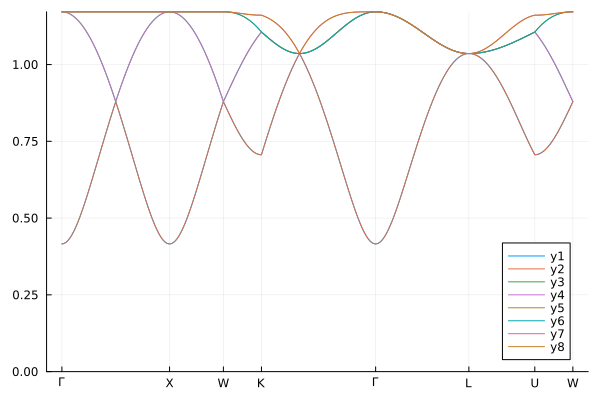

In [19]:
pfad = split("\\Gamma X W K \\Gamma L U W")

t, K, ticks = generate_path(high_symmetry_points, pfad, 128)


sim = SimulationParameters(A_dict["0flux"], -0.15, [0.0,0.0,0.0], 1000, 1.0)

E = reduce(vcat, map(k-> spinon_dispersion(k, sim)[1], K*2π/8)')

plot(t,E)
xticks!(ticks, pfad)
ylims!(0.,maximum(E))

## Calculating the spectral weight

We now calculate
$$\begin{align}
\langle S^+(\mathbf{q}, t)S^-(\mathbf{-q},0)\rangle = 
&\frac{1}{4f^{2}N_{\rm spin }}\sum_{\begin{smallmatrix}\mathbf{k}&r_{A}&\mu\\ \mathbf{k}'&r_A'&\nu\end{smallmatrix}}
e^{iA_{r_A,r_A+b_\mu}-iA_{r_A',r_A'+b_\nu}}~e^{i \mathbf{k}\cdot \mathbf{b}_{\mu}-i \mathbf{k}'\cdot \mathbf{b}_{\nu}}
\times\left\langle 
\phi_{\mathbf{r}_{A}} ^{*}(\mathbf{k}+ \frac{\mathbf{q}}{2},t)\,
\phi_{\mathbf{r}_A+\mathbf{b}_\mu}(\mathbf{k}-\frac{\mathbf{q}}{2},t)~
\phi_{\mathbf{r}'_{A}+\mathbf{b}_\nu} ^{*}(\mathbf{k}'+ \frac{\mathbf{q}}{2},0)\,
\phi_{\mathbf{r}'_A}(\mathbf{k}'-\frac{\mathbf{q}}{2},0)
 \right\rangle
 \end{align}
$$
setting $K = \frac{1}{2}(k+k')$, $p=k-k'$, get
$$= \sum_{\mu,\nu} 
\left(\sum_{\mathbf{K}}\frac{1}{4f^2N_{\rm spin}} e^{i \mathbf{K}\cdot (b_\mu - b_\nu)}\right)
e^{iA_{r_A,r_A+b_\mu}-iA_{r_A',r_A'+b_\nu}}
\sum_{\mathbf{p},r_A,r'_A} 
 e^{i \mathbf{p}\cdot (b_\mu + b_\nu)/2}
\mathcal{G}_{r_A,r'_A}(\mathbf{p}+\mathbf{q}, t)\mathcal{G}_{r'_A+b_\nu,r_A+b_\mu}(-\mathbf{p}+\mathbf{q}, -t)
$$


The zero-temperature Green function, in terms of spinon energies $\mathcal{E}_l(\mathbf{k}) = \sqrt{2J_{zz}(\lambda+\epsilon_{l}(\mathbf{k}))}$
is
$$
\begin{align}
\mathcal{G}_{ab}(\mathbf{k},\omega) = \sum_{l=1}^{f}\frac{2J_{zz}U_{al} (\mathbf{k})U^{\dagger}_{lb}(\mathbf{k})}{-\omega^{2}+\mathcal{E}_l(\mathbf{k})^2}\\
= \sum_{l=1}^{f}{2J_{zz}U_{al} (\mathbf{k})U^{\dagger}_{lb}(\mathbf{k})}
\frac{1}{2\mathcal{E}_l(\mathbf{k})}
\left[ \frac{-1}{\omega-\mathcal{E}_l(\mathbf{k})} + \frac{1}{\omega+\mathcal{E}_l(\mathbf{k})} \right]
\end{align}
$$

Thus rendering the spin-spin response
$$
\begin{align*}
\mathcal{S}_{r_A\,\mu\;r_A'\,\nu}(\mathbf{q},\omega)=&
\sum_{\mathbf{\Delta}}\sum_{\begin{smallmatrix}r_{A}&\mu\\ r_A'&\nu\end{smallmatrix}}F_{\mu\nu}(\mathbf{\Delta})~
e^{iA_{r_A,r_A+b_\mu}-iA_{r_A',r_A'+b_\nu}}\,\times\\
&\int \frac{d\omega_{1}}{2\pi}\,
\mathcal{G}_{r_{A}\,r_{A}'}(\mathbf{\Delta}+\mathbf{q}, \omega_1)~
\mathcal{G}_{r_A+\mu\,r_A'+\nu}\,(-\mathbf{\Delta}+\mathbf{q},\omega_1-\omega)
\end{align*}
$$


In [20]:
using IJulia

pfad = split("\\Gamma X W K \\Gamma L U W")

t, K, ticks = generate_path(high_symmetry_points, pfad, 10)

# print(length(t))

sim = SimulationParameters(A_dict["FF_even"], 0.25, [0.2,0.2,0.2], 1000, 1.0)
Egrid = range(0,4,1000)


S = zeros(ComplexF64, length(K), length(Egrid))
lowerb = zeros(Float64, length(K))
upperb = zeros(Float64, length(K))

for (I, q) in enumerate(K*2π/8)
    IJulia.clear_output(true)    
    println(I,"/",length(K))
    S[I, :], (lowerb[I], upperb[I]) = spectral_weight(q, Egrid, sim, 100, 1000)
end


1/53


LoadError: InterruptException:

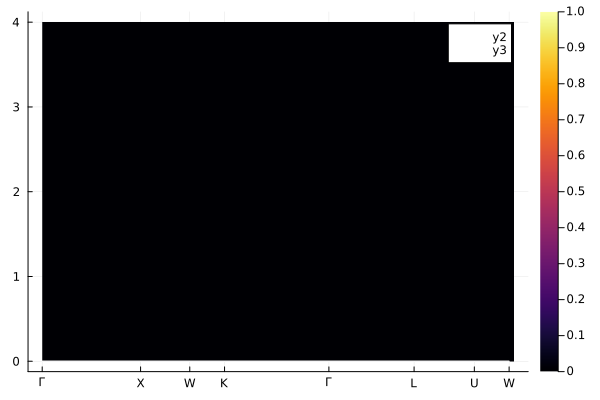

In [15]:
IJulia.clear_output(false)
heatmap(t,Egrid, real.(S)' )
plot!(t, lowerb, linecolor=:white)
plot!(t, upperb, linecolor=:white)
xticks!(ticks, pfad)
# ylims!(0.,maximum(E))

In [16]:
Plots.set_default_backend!(:pythonplot)


LoadError: UndefVarError: set_default_backend! not defined